# TABLES

In [ ]:

import pandas as pd
import os
import sys
from os import path
from dotenv import load_dotenv

random_seed = 42
load_dotenv()
sys.path.append(path.dirname(os.getcwd()))

# Load the CSV file
file_path = "Results Analysis - Summary.csv"
df = pd.read_csv(file_path)
df = df.sort_values(by="Model", key=lambda x: x.str.len())

df.replace("#DIV/0!", "-", inplace=True)


In [27]:
# Selecting relevant columns and renaming them for clarity
precision_recall_columns = ["Model", "Prompt", "True Class Precision", "True Class Recall"]
precision_recall_balanced_columns = ["Model", "Prompt", "Bal True Class Precision", "Bal True Class Recall"]
NEC_columns = ["Model", "Prompt", "NEC", "NEC reduce FN", "NEC reduce FP"]
NEC_balanced_columns = ["Model", "Prompt", "Bal NEC", "Bal NEC reduce FN", "Bal NEC reduce FP"]
NEC_realistic_columns = ["Model", "Prompt", "NEC realistic", "NEC reduce FN realistic", "NEC reduce FP realistic"]

precision_recall_caption = "Model performance: Precision and Recall."
precision_recall_balanced_caption = "Model performance: Precision and Recall in a balanced setting."
NEC_caption = "Model performance: NEC, NEC reducing FN, and NEC reducing FP."
NEC_balanced_caption = "Model performance: Balanced NEC, Balanced NEC reducing FN, and Balanced NEC reducing FP."
NEC_realistic_caption = "Model performance: Realistic NEC, Realistic NEC Reducing FN, and Realistic NEC Reducing FP."

columns_caption__format_items = [
    (precision_recall_columns, precision_recall_caption, "l l c c"),
    (precision_recall_balanced_columns, precision_recall_balanced_caption, "l l c c"),
    (NEC_columns, NEC_caption, "l l c c c"),
    (NEC_balanced_columns, NEC_balanced_caption, "l l c c c"),
    (NEC_realistic_columns, NEC_realistic_caption, "l l c c c")
]

for columns, caption, format in columns_caption__format_items:
    df_filtered = df[columns]

    # Generate LaTeX table using to_latex method
    latex_table = df_filtered.to_latex(index=False, column_format=format, caption=caption, float_format="%.3f", position="H")

    # Output the LaTeX table
    print(latex_table)

\begin{table}[H]
\caption{Model performance: Precision and Recall.}
\begin{tabular}{l l c c}
\toprule
Model & Prompt & True Class Precision & True Class Recall \\
\midrule
Mean Predictor & none & 0.357 & 0.357 \\
Always Positive & none & 0.357 & 1.000 \\
Always Negative & none & - & 0.000 \\
Roberta 3Epochs & none & 0.695 & 0.633 \\
ensemble-small-models & simple & 0.551 & 0.884 \\
ensemble-small-models & definition & 0.512 & 0.939 \\
google/gemma-1.1-7b-it & definition & 0.474 & 0.944 \\
google/gemma-1.1-7b-it & simple & 0.421 & 0.968 \\
meta-llama/Llama-3.1-8B-Instruct & definition & 0.518 & 0.914 \\
meta-llama/Llama-3.1-8B-Instruct & simple & 0.559 & 0.859 \\
meta-llama/Llama-3.3-70B-Instruct & simple & 0.567 & 0.920 \\
meta-llama/Llama-3.3-70B-Instruct & definition & 0.618 & 0.852 \\
mistralai/Mistral-7B-Instruct-v0.2 & definition & 0.520 & 0.887 \\
mistralai/Mistral-7B-Instruct-v0.2 & simple & 0.645 & 0.674 \\
meta-llama/Llama-3.2-11B-Vision-Instruct & definition & 0.396 & 0.949 \

# Graphs

In [36]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load the dataset
file_path = "Results Analysis - Summary.csv"
df = pd.read_csv(file_path)
df = df.sort_values(by="Model", key=lambda x: x.str.len())

df.replace("#DIV/0!", -1, inplace=True)
df.fillna(-1, inplace=True)
df["True Class Precision"] = df["True Class Precision"].astype(float)
df["Bal True Class Precision"] = df["Bal True Class Precision"].astype(float)

light_red = "#ff9999"
medium_red = "#ff6666"
dark_red = "#cc0000"

light_blue = "#9999ff"
dark_blue = "#0000cc"

light_green = "#98df8a"
dark_green = "#2ca02c"

no_pattern = None
diagonal_lines = "\\\\"

plt.rcParams.update({"font.size": 16})

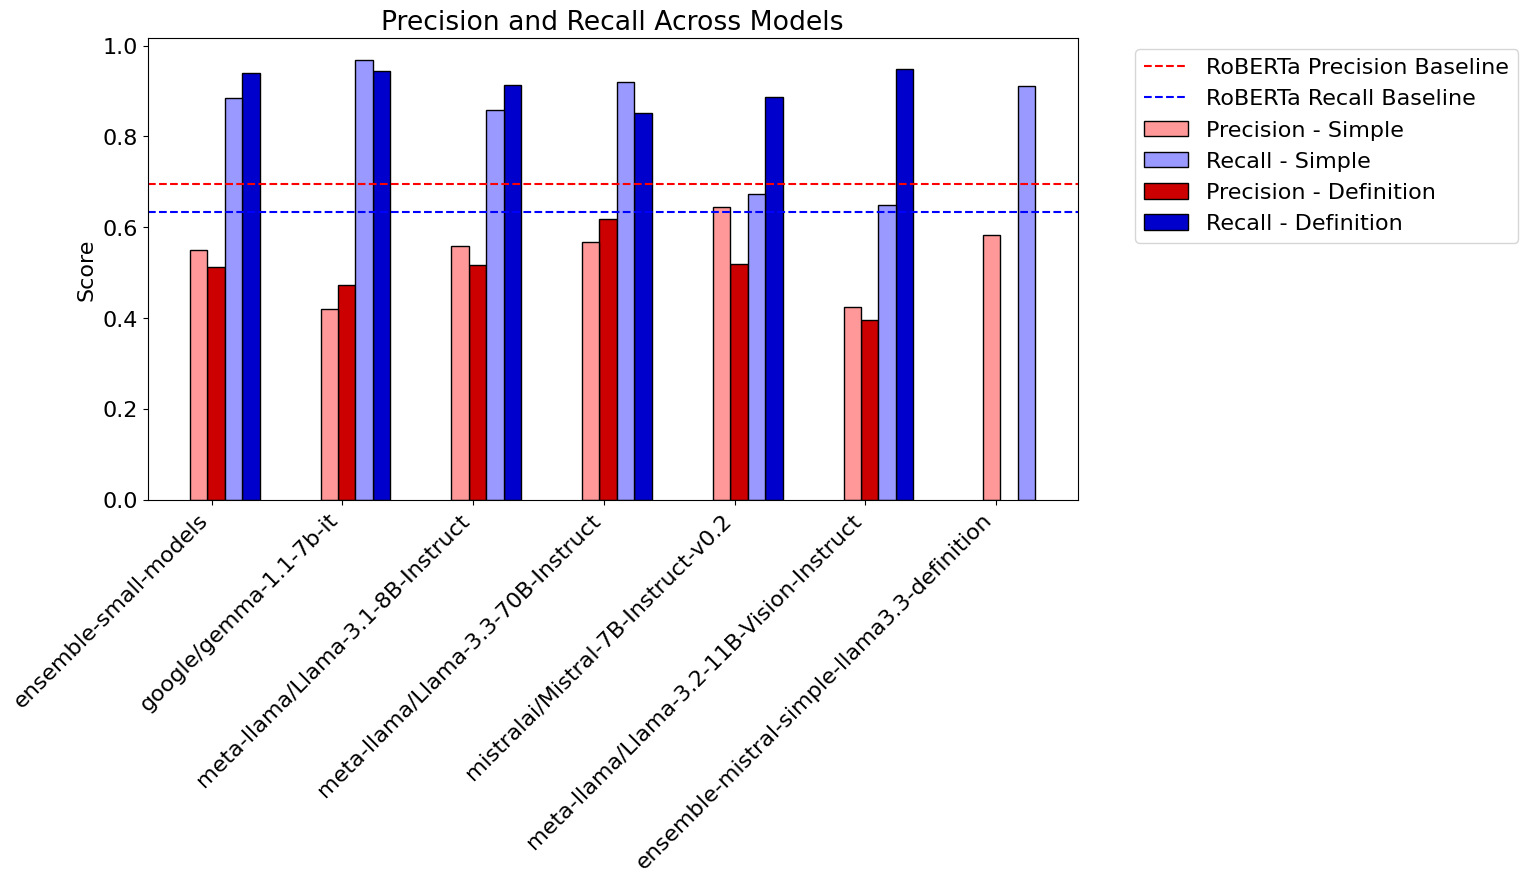

In [37]:
# Adjust bar positioning to include ensemble model without prompt while keeping correct order
fig, ax = plt.subplots(figsize=(12, 6))

metric_prompt_colors = {
    "Precision - Simple": (light_red, no_pattern),
    "Recall - Simple": (light_blue, no_pattern),
    "Precision - Definition": (dark_red, no_pattern),
    "Recall - Definition": (dark_blue, no_pattern),
    "Precision - Simple Balanced": (light_red, diagonal_lines),
    "Recall - Simple Balanced": (light_blue, diagonal_lines),
    "Precision - Definition Balanced": (dark_red, diagonal_lines),
    "Recall - Definition Balanced": (dark_blue, diagonal_lines),
}

# Filter out baseline models
df_filtered = df[~df["Model"].isin(["Always Positive", "Always Negative", "Mean Predictor"])].copy()
grouped = df_filtered.groupby(["Model", "Prompt"]).mean(numeric_only=True).reset_index()
unique_models = grouped["Model"].unique()
unique_models = unique_models[np.argsort([len(s) for s in unique_models])]


# Compute RoBERTa baseline values
roberta_baseline = df_filtered[df_filtered["Model"].str.contains("roberta", case=False)]
precision_baseline = roberta_baseline["True Class Precision"].mean()
recall_baseline = roberta_baseline["True Class Recall"].mean()

# X positions for each model (excluding RoBERTa)
x_positions = {}
offset = 0
bar_width = 0.4  # Standard width for clear separation

for model in unique_models:
    if "roberta" in model.lower():
        continue  # Skip plotting RoBERTa's bars
    x_positions[model] = offset
    offset += 3  # Ensure enough spacing between models

# Create bars with specific colors and spacing in the correct order
plotted_labels = set()  # Track labels to avoid duplicates in legend

for (model, prompt), subset in grouped.groupby(["Model", "Prompt"]):
    if "roberta" in model.lower():
        continue  # Skip plotting RoBERTa's bars
    
    x_base = x_positions[model]

    # Ensure correct order: Precision Simple, Precision Definition, Recall Simple, Recall Definition
    if prompt == "simple":
        x_prec = x_base
        x_rec = x_base + 2 * bar_width
    elif prompt == "definition":
        x_prec = x_base + bar_width
        x_rec = x_base + 3 * bar_width
    elif pd.isna(prompt) or prompt == "none":  # Handle ensemble model without prompt
        x_prec = x_base + 0.5 * bar_width  # Slightly shift to align well
        x_rec = x_base + 2.5 * bar_width
    else:
        continue  # Skip unexpected prompt types

    prec_label = f"Precision - {prompt.capitalize() if prompt != 'none' else 'Simple'}" 
    rec_label = f"Recall - {prompt.capitalize() if prompt != 'none' else 'Simple'}"

    # Only add labels once to avoid duplicates in the legend
    ax.bar(
        x_prec,
        subset["True Class Precision"].values[0],
        width=bar_width, 
        color=metric_prompt_colors.get(prec_label, light_red),  
        label=prec_label if prec_label not in plotted_labels else None,
        edgecolor="black",
        )
    ax.bar(
        x_rec, 
        subset["True Class Recall"].values[0],
        width=bar_width, 
        color=metric_prompt_colors.get(rec_label, light_blue),  
        label=rec_label if rec_label not in plotted_labels else None,
        edgecolor="black",
        )
    
    plotted_labels.add(prec_label)
    plotted_labels.add(rec_label)

# Add horizontal lines for RoBERTa model
ax.axhline(precision_baseline, linestyle="dashed", color="red", label="RoBERTa Precision Baseline")
ax.axhline(recall_baseline, linestyle="dashed", color="blue", label="RoBERTa Recall Baseline")

# Labels and legend
ax.set_xticks([x + 0.3 for x in x_positions.values()])
ax.set_xticklabels([model for model in unique_models if "roberta" not in model.lower()], rotation=45, ha="right")
ax.set_ylabel("Score")
ax.set_title("Precision and Recall Across Models")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.savefig("precision_recall.svg", bbox_inches="tight")
plt.show()


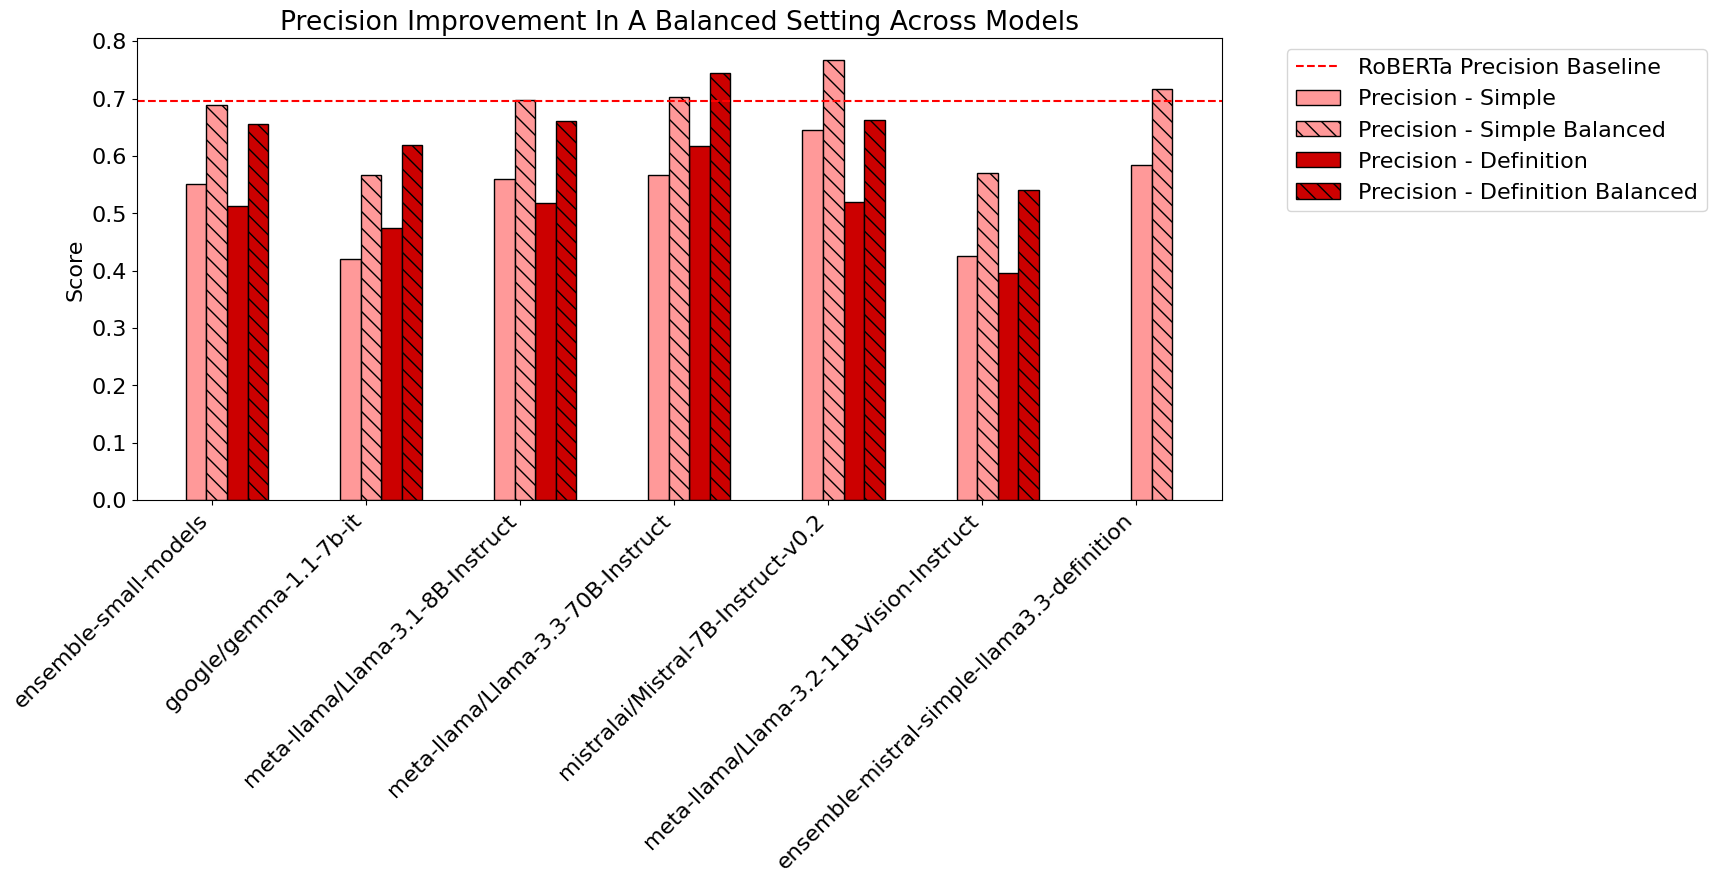

In [39]:
# Update color mapping to handle "none" prompt properly
metric_prompt_colors = {
    "Precision - Simple": (light_red, no_pattern),  
    "Precision - Simple Balanced": (light_red, diagonal_lines),
    "Precision - Definition": (dark_red, no_pattern), 
    "Precision - Definition Balanced": (dark_red, diagonal_lines),
}

# Filter out baseline models
df_filtered = df[~df["Model"].isin(["Always Positive", "Always Negative", "Mean Predictor"])].copy()
grouped = df_filtered.groupby(["Model", "Prompt"]).mean(numeric_only=True).reset_index()
unique_models = grouped["Model"].unique()
unique_models = unique_models[np.argsort([len(s) for s in unique_models])]

# Compute RoBERTa baseline values
roberta_baseline = df_filtered[df_filtered["Model"].str.contains("roberta", case=False)]
precision_baseline = roberta_baseline["True Class Precision"].mean()

# Re-run the plotting
fig, ax = plt.subplots(figsize=(14, 6))

# Create bars
plotted_labels = set()
for (model, prompt), subset in grouped.groupby(["Model", "Prompt"]):
    if "roberta" in model.lower():
        continue
    x_base = x_positions[model]
    
    if prompt == "simple":
        x_prec = x_base
        x_prec_bal = x_base + bar_width
    elif prompt == "definition":
        x_prec = x_base + 2 * bar_width
        x_prec_bal = x_base + 3 * bar_width
    elif prompt == "none":
        x_prec = x_base + bar_width
        x_prec_bal = x_base + 2 * bar_width
    else:
        continue
    
    prec_label = f"Precision - {prompt.capitalize() if prompt != 'none' else 'Simple'}"
    prec_bal_label = f"Precision - {prompt.capitalize() if prompt != 'none' else 'Simple'} Balanced"
    
    color, pattern = metric_prompt_colors[prec_label]
    color_bal, pattern_bal = metric_prompt_colors[prec_bal_label]

    ax.bar(x_prec,
           subset["True Class Precision"].values[0],
           width=bar_width, 
           color=color,
           hatch=pattern,
           label=prec_label if prec_label not in plotted_labels else None,
           edgecolor="black",
           )
    ax.bar(x_prec_bal,
           subset["Bal True Class Precision"].values[0],
           width=bar_width, 
           color=color_bal,
           hatch=pattern_bal, 
           label=prec_bal_label if prec_bal_label not in plotted_labels else None,
           edgecolor="black",
           )
    
    plotted_labels.update([prec_label, prec_bal_label])

# Add horizontal line for RoBERTa baseline
ax.axhline(precision_baseline, linestyle="dashed", color="red", label="RoBERTa Precision Baseline")

# Labels and legend
ax.set_xticks([x + 0.3 for x in x_positions.values()])
ax.set_xticklabels([model for model in unique_models if "roberta" not in model.lower()], rotation=45, ha="right")
ax.set_ylabel("Score")
ax.set_title("Precision Improvement In A Balanced Setting Across Models")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.savefig("precision_recall_balanced.svg", bbox_inches="tight")
plt.show()

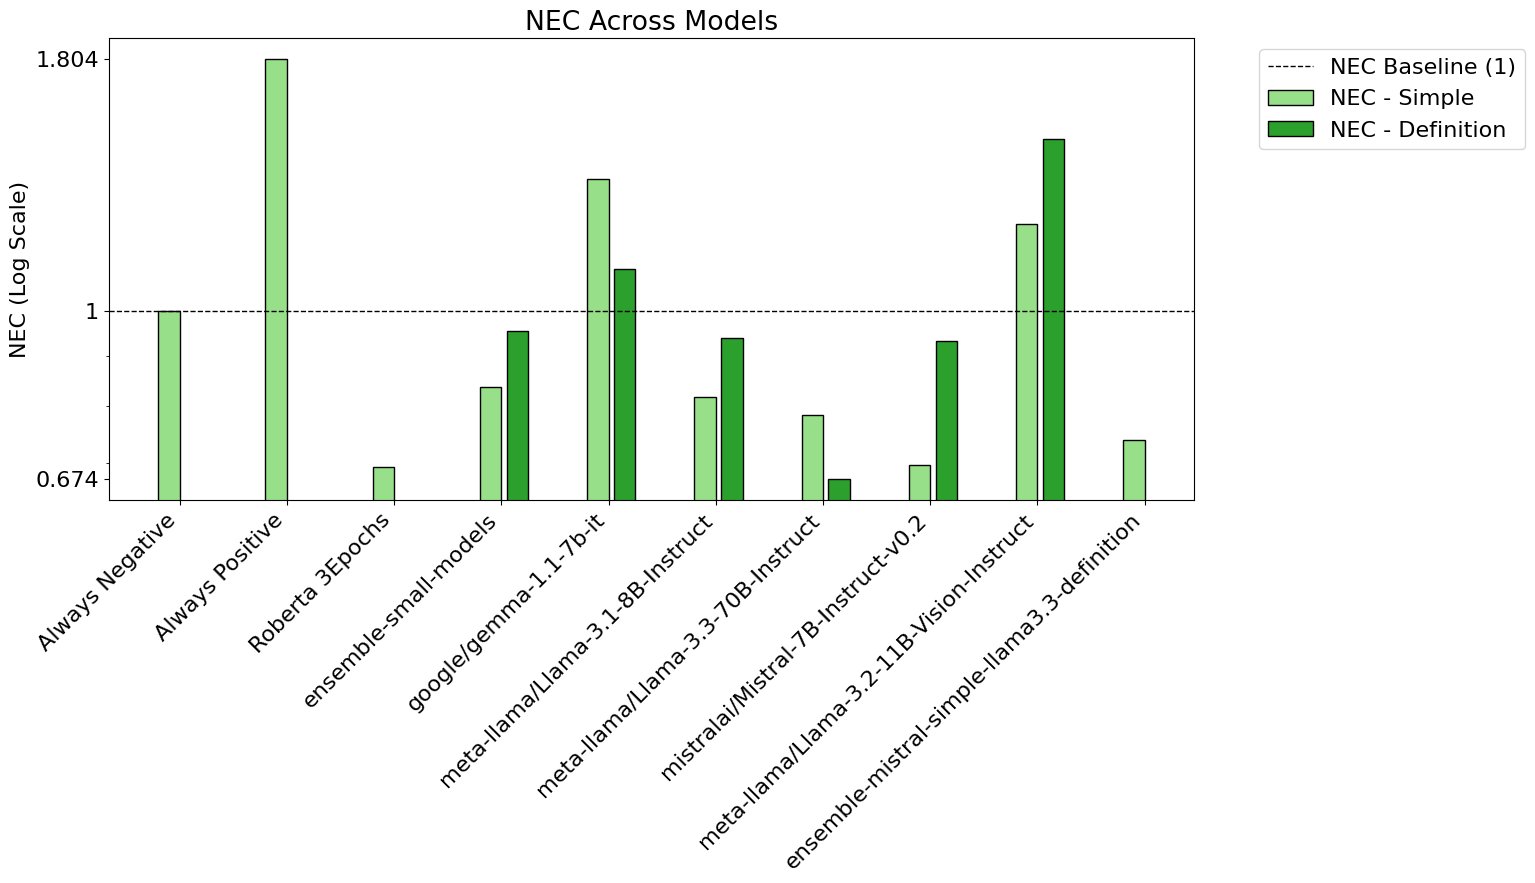

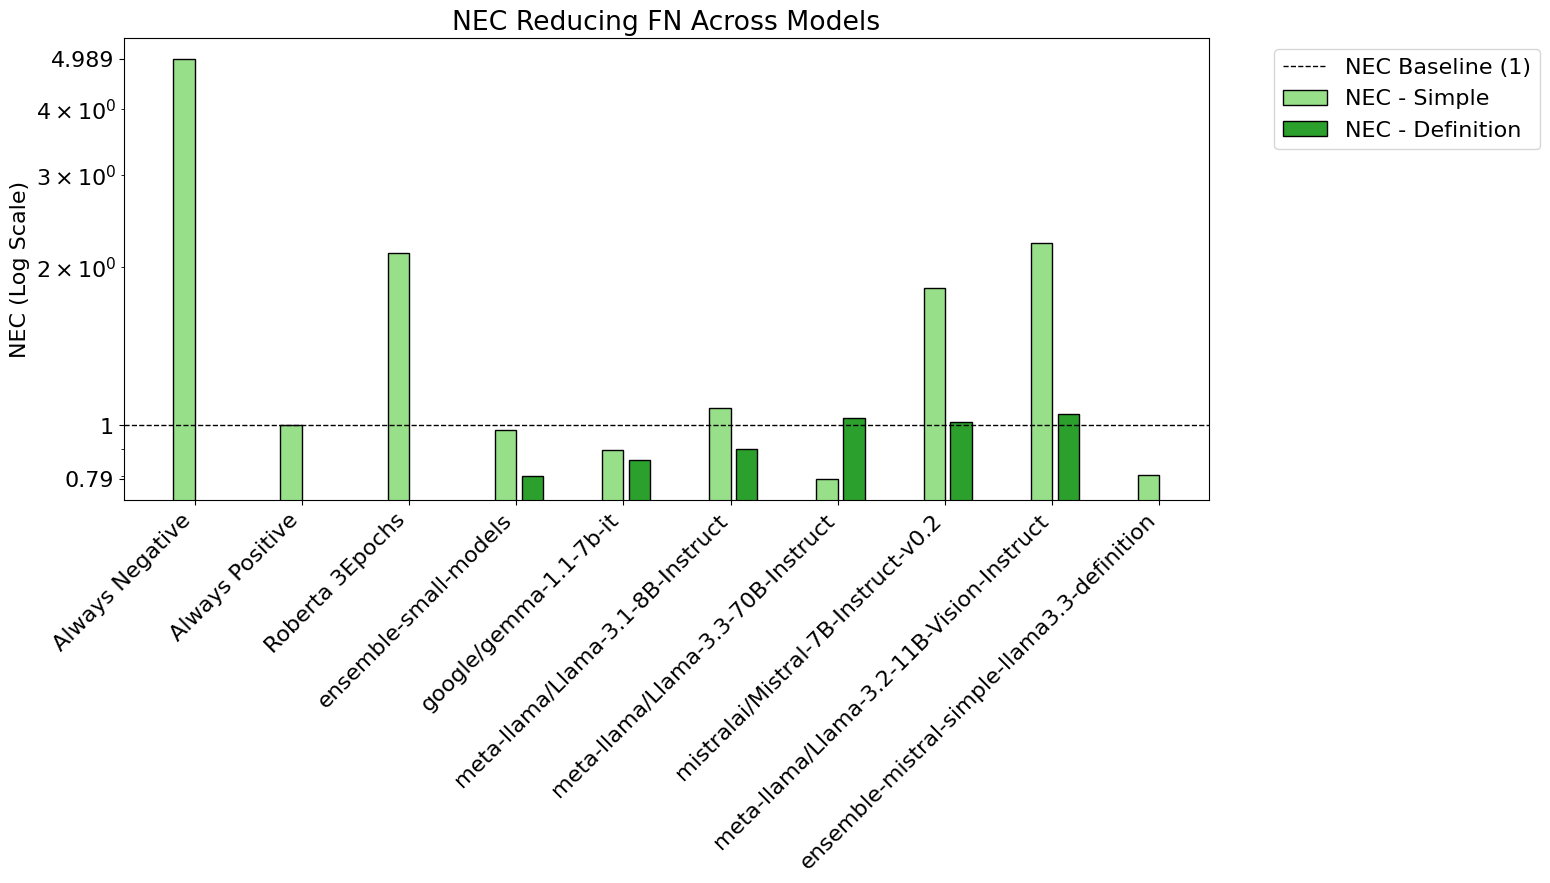

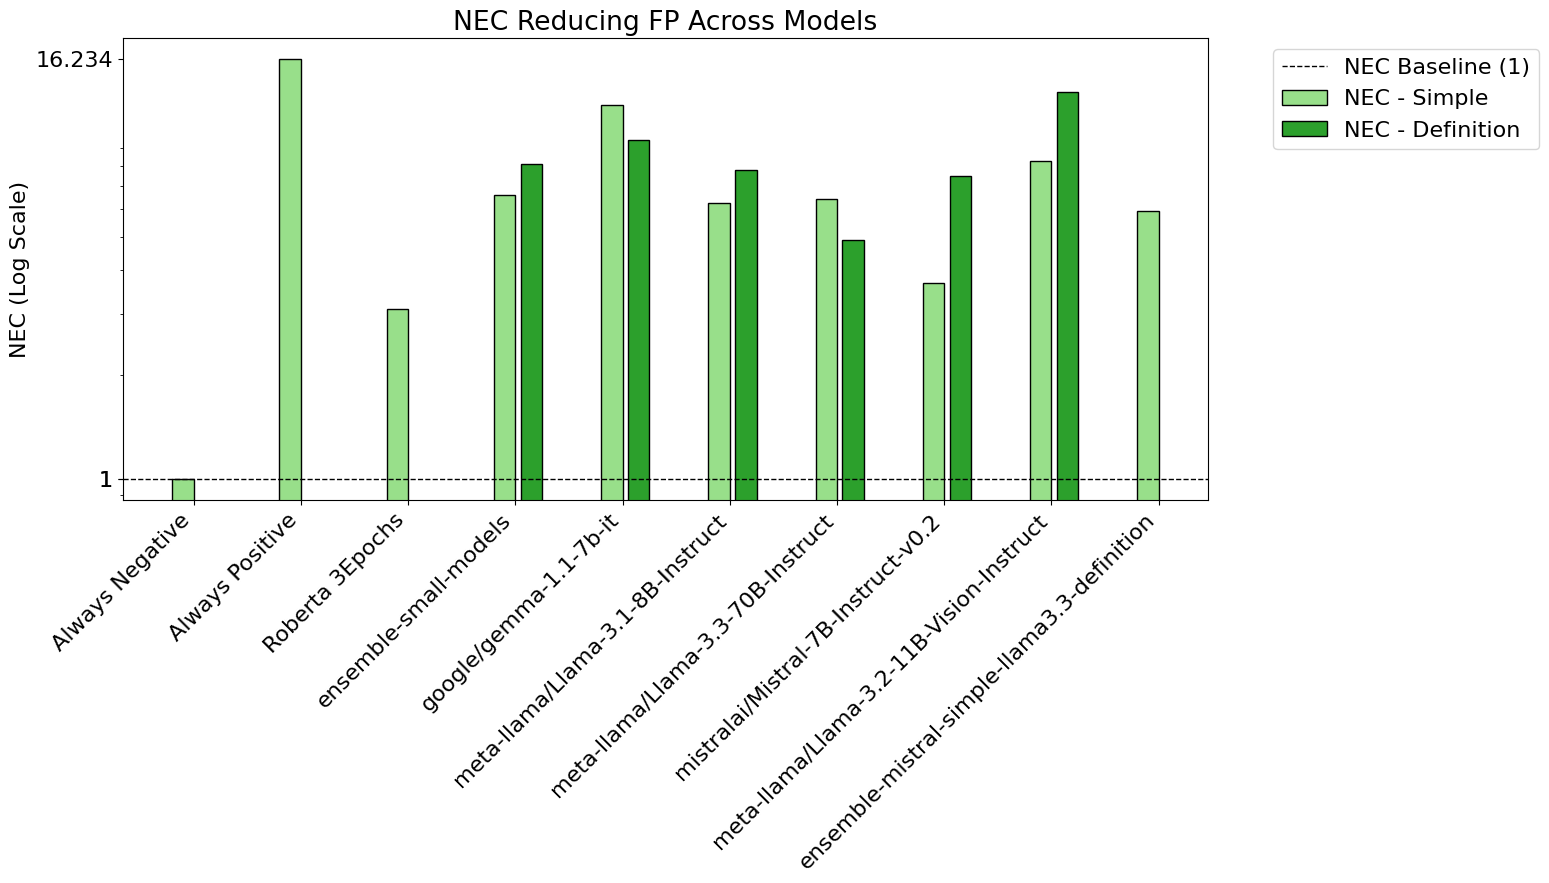

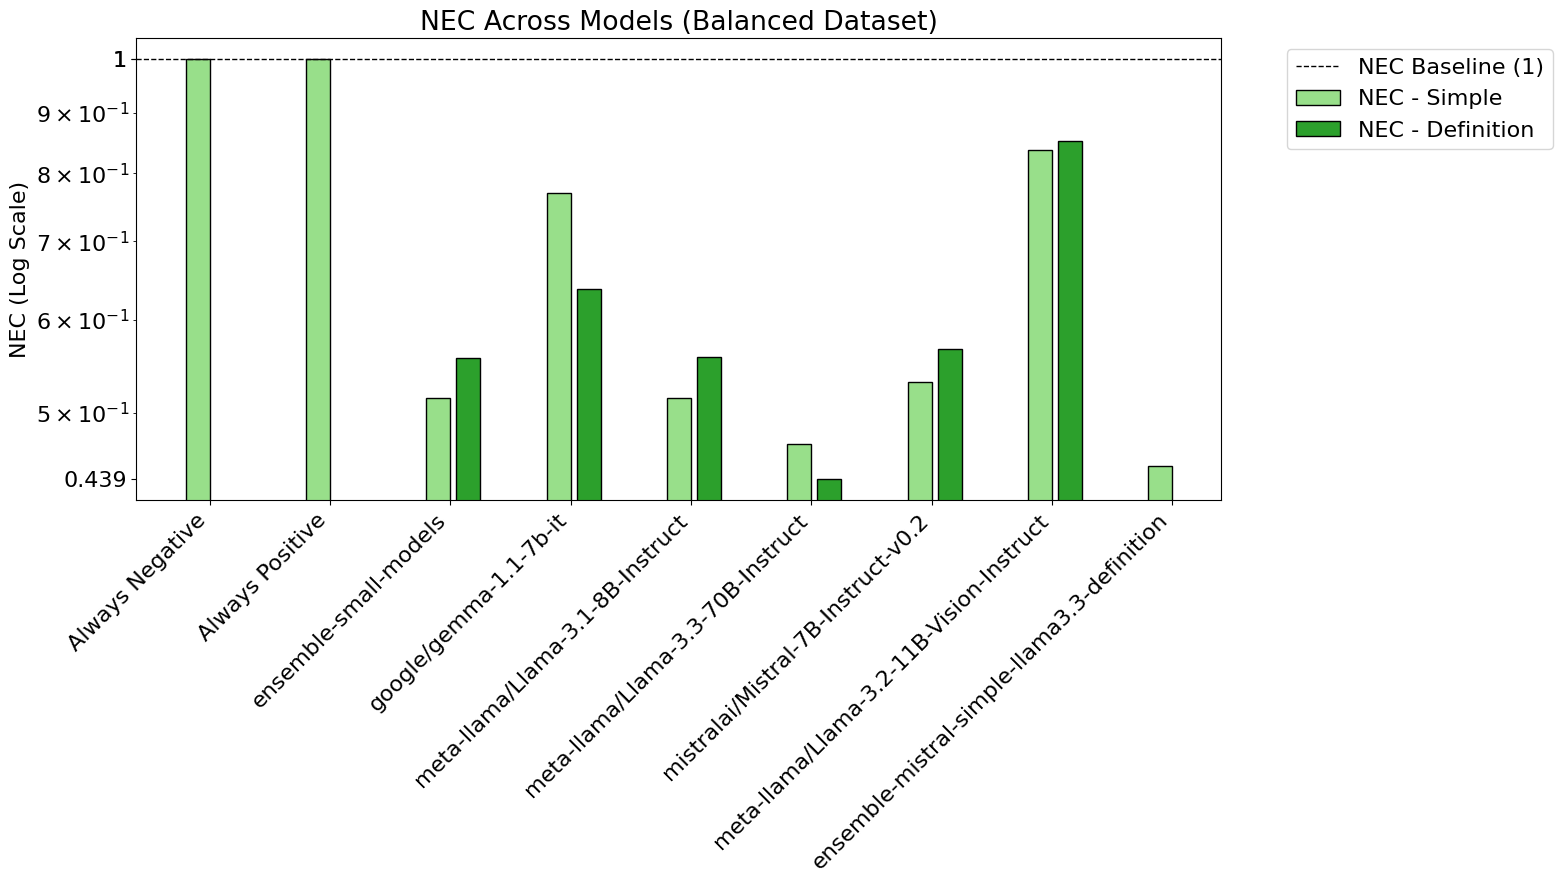

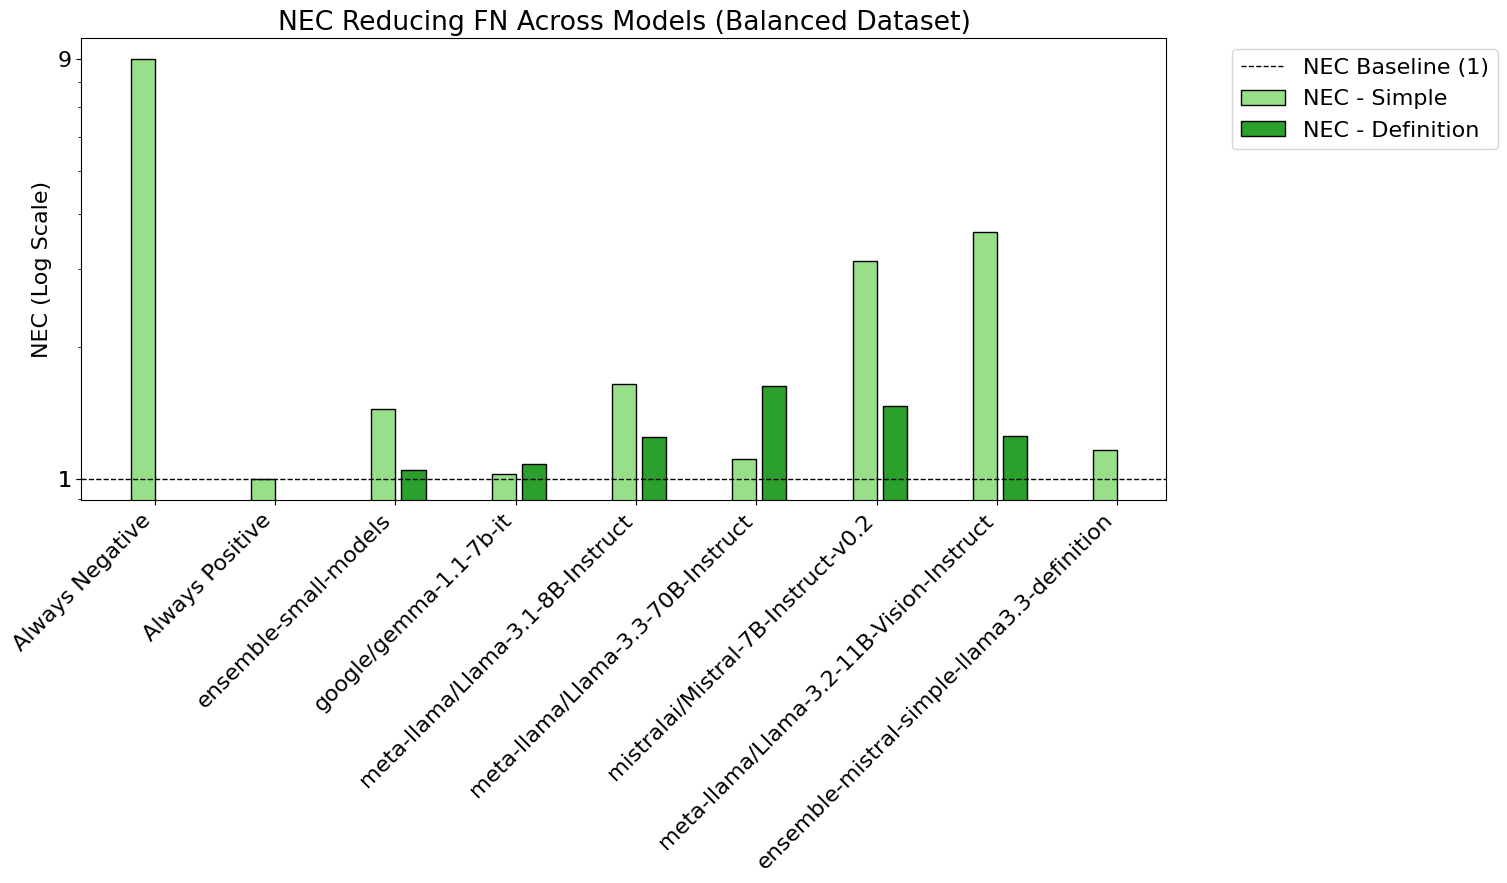

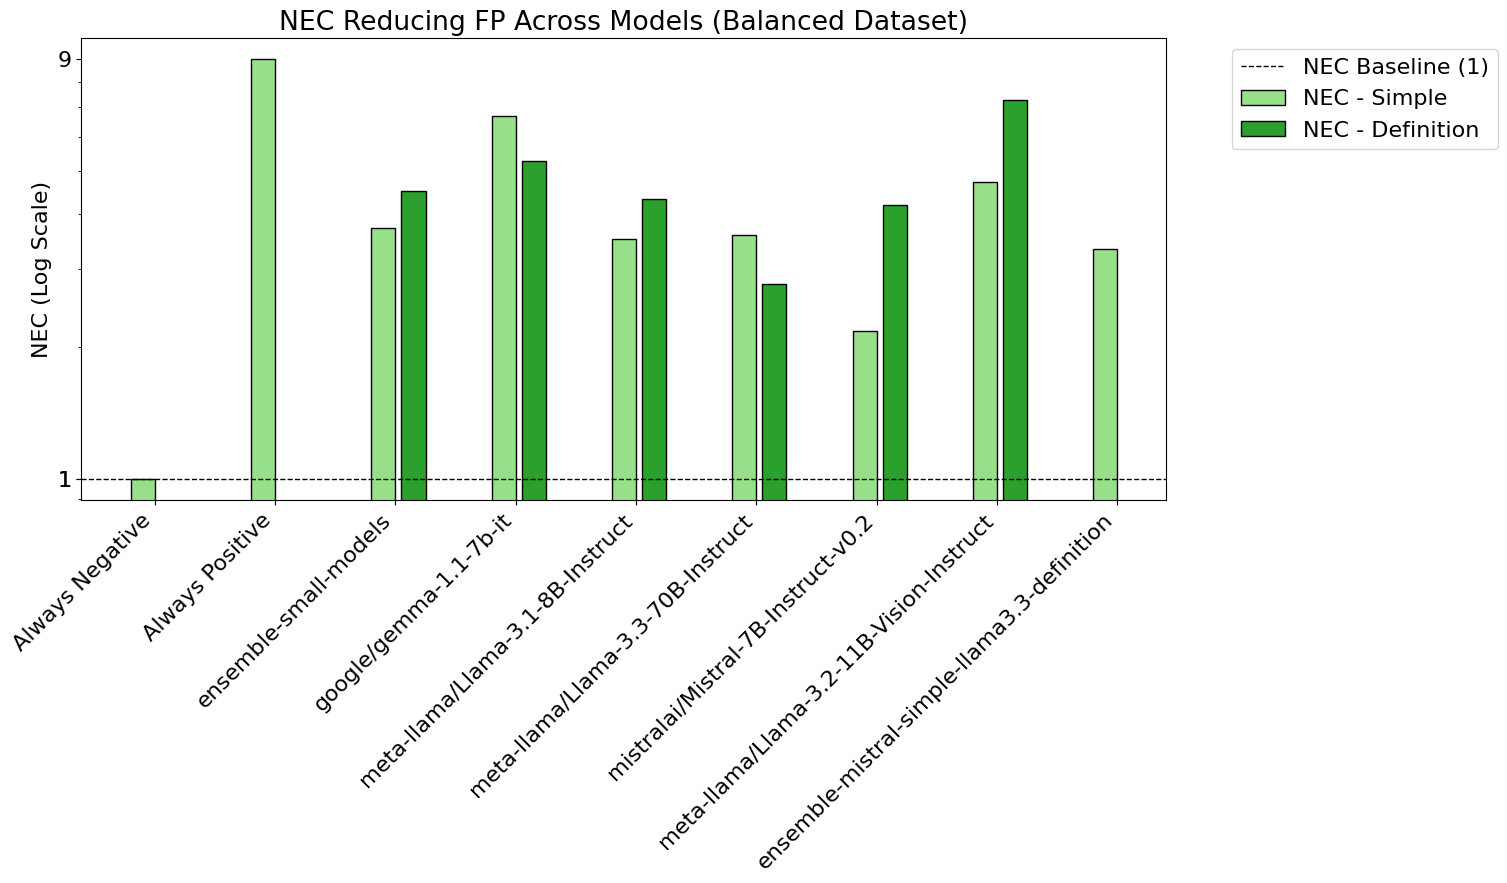

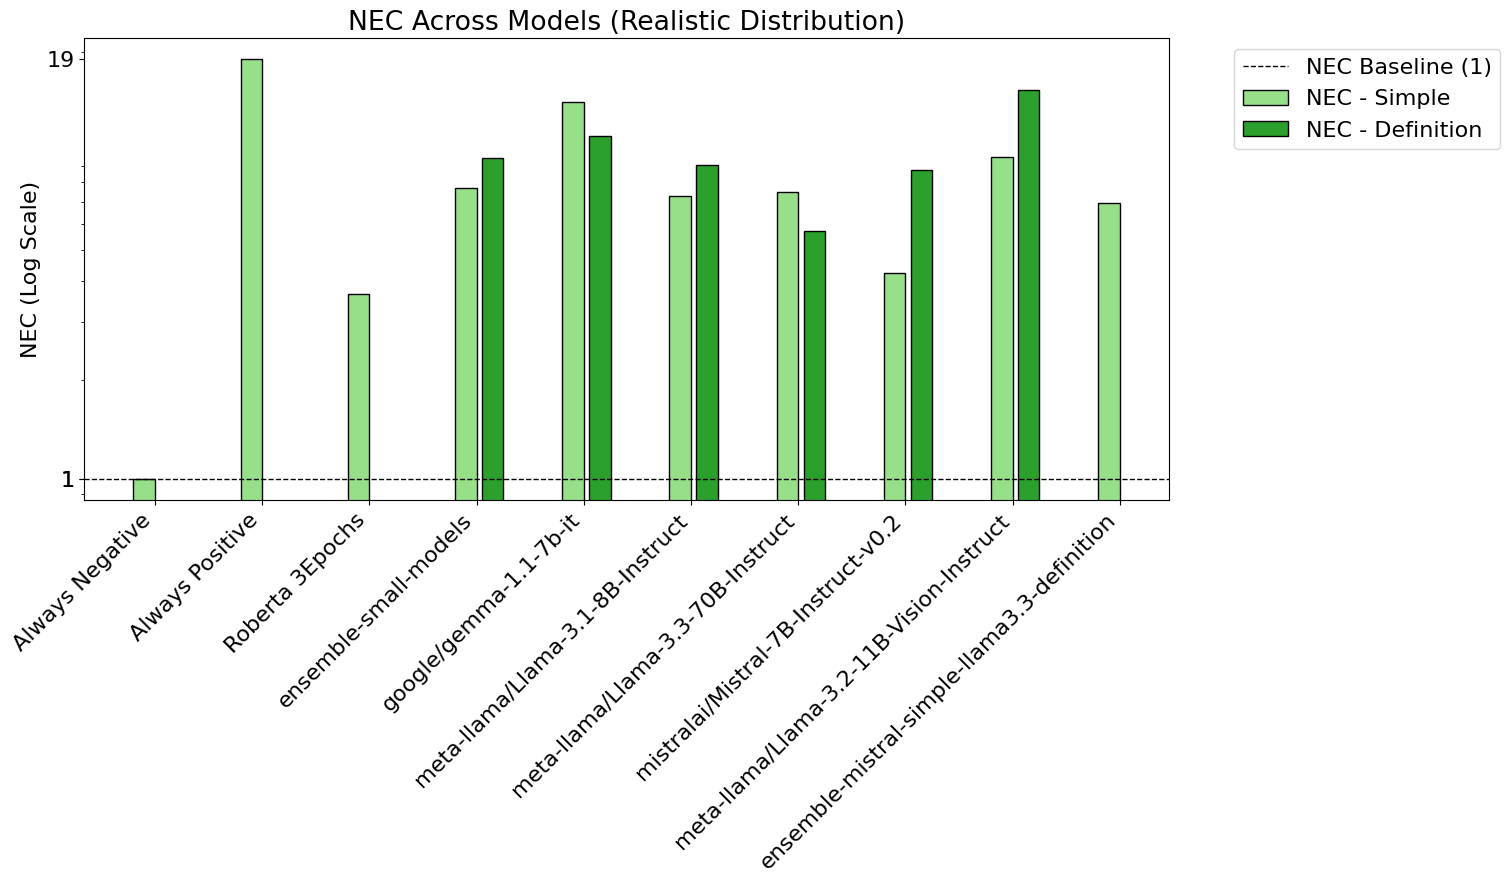

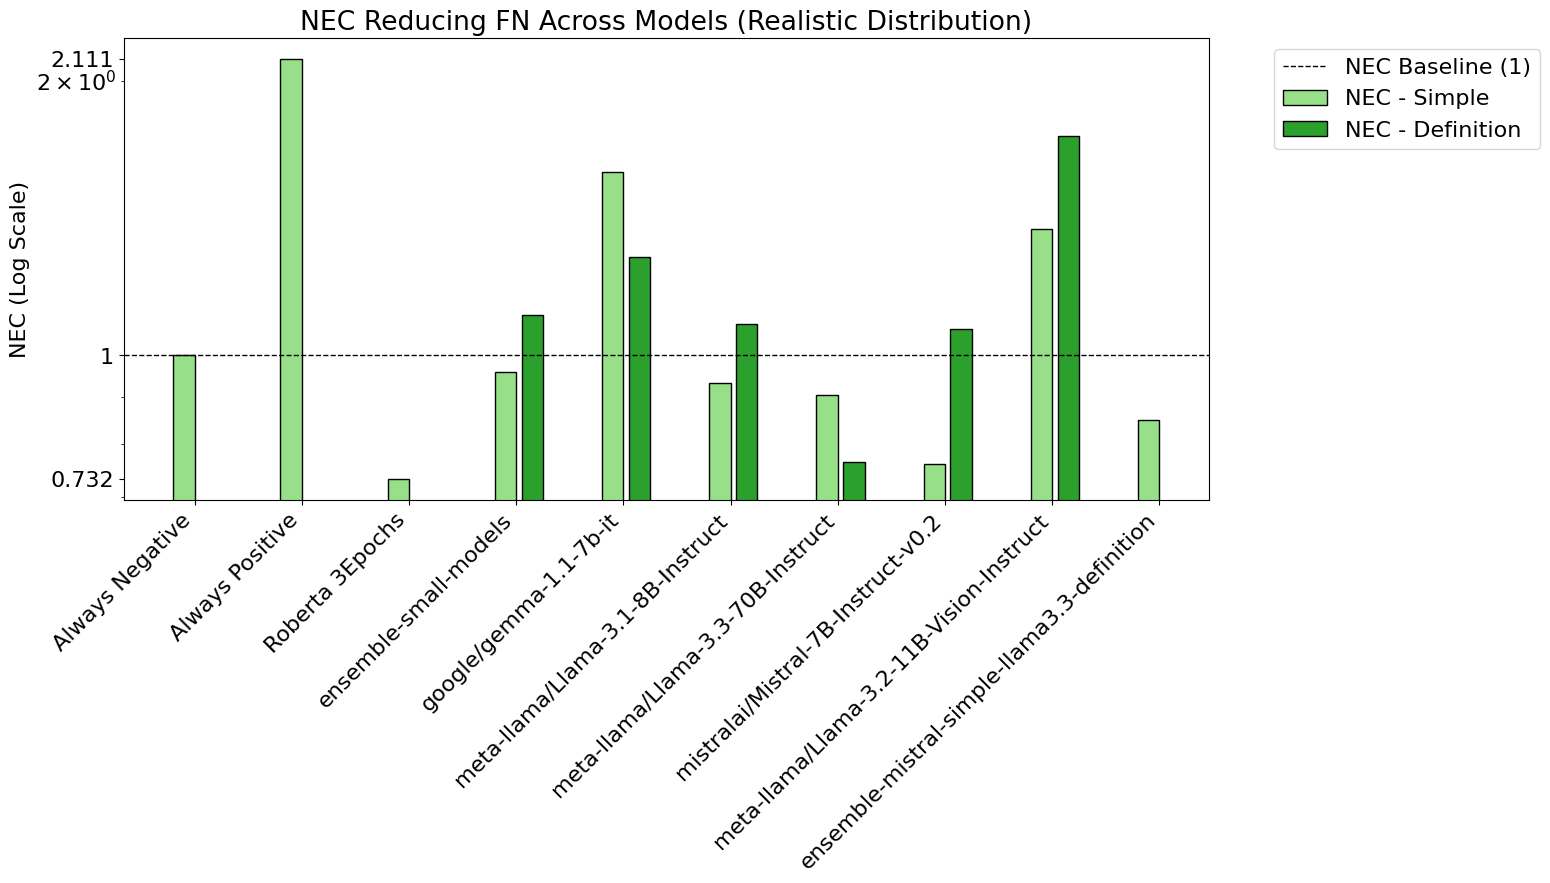

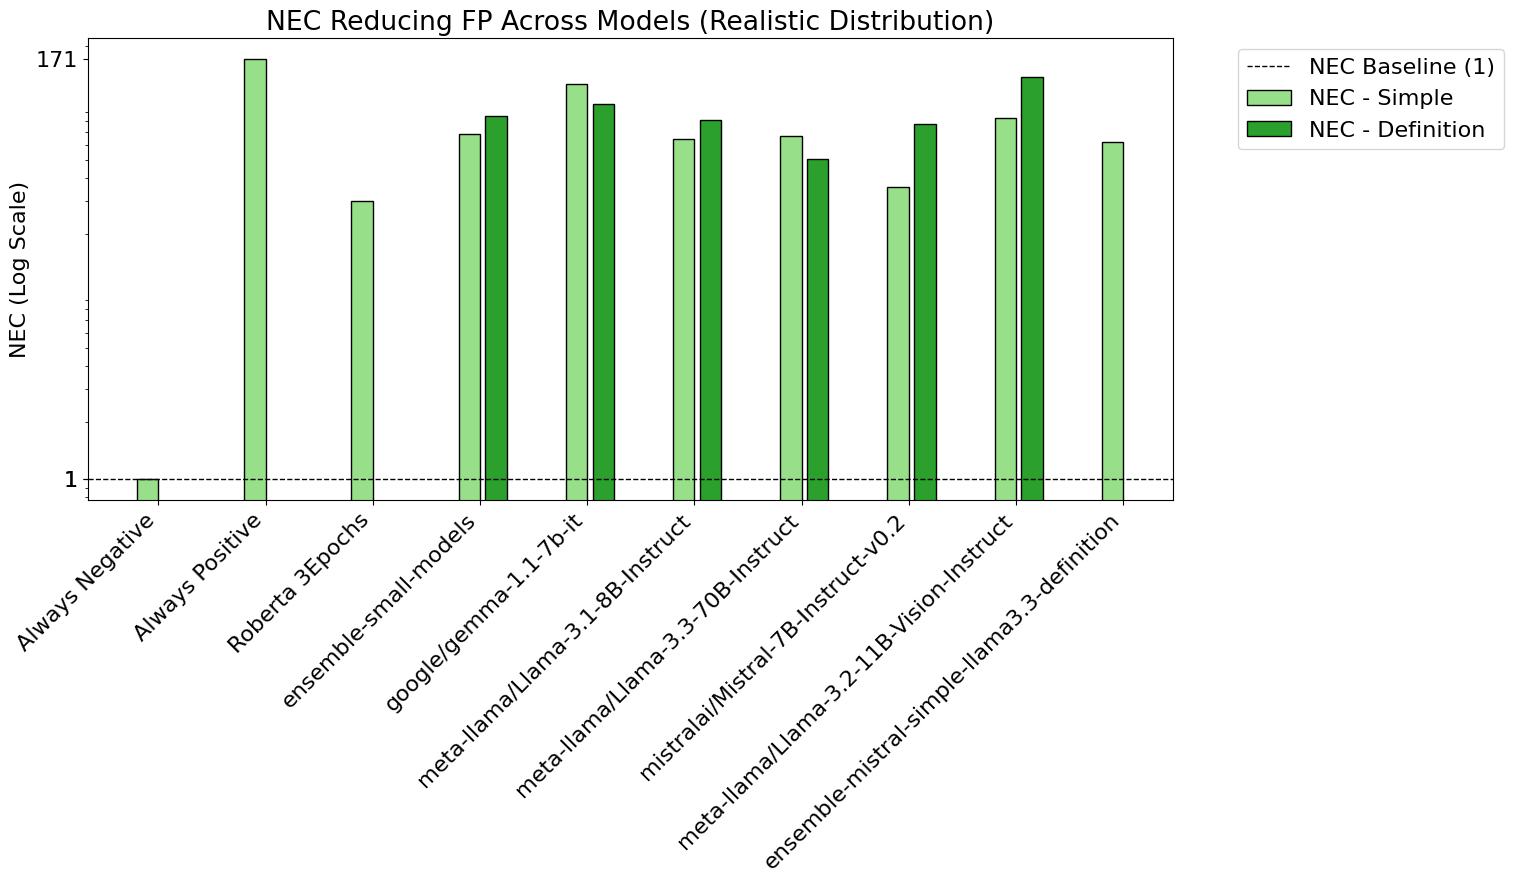

In [40]:
def show_nec_graph(nec_metric: str, nice_name: str, title: str, models_to_exclude: list[str] = ["Mean Predictor"]) -> None:
    # Filter out baseline models
    df_filtered = df[~df["Model"].isin(models_to_exclude)].copy()
    grouped = df_filtered.groupby(["Model", "Prompt"]).mean(numeric_only=True).reset_index()
    unique_models = grouped["Model"].unique()
    unique_models = unique_models[np.argsort([len(s) for s in unique_models])]

    # Define colors
    metric_colors = {
        "Simple": light_green, 
        "Definition": dark_green,
    }

    # Plot histogram with log scale
    fig, ax = plt.subplots(figsize=(14, 6))

    # X positions for each model
    x_positions = {}
    offset = 0
    bar_width = 0.4  # Adjusted width

    for model in unique_models:
        x_positions[model] = offset
        offset += 2  # Spacing between models

    # Create bars
    plotted_labels = set()
    for (model, prompt), subset in grouped.groupby(["Model", "Prompt"]):
        x_base = x_positions[model]
        
        if prompt == "definition":
            x_nec = x_base + 0.5
        else:
            x_nec = x_base
        
        nec_label = f"{nice_name} - {prompt.capitalize() if prompt != 'none' else 'Simple'}"
        
        ax.bar(
            x_nec,
            subset[nec_metric].values[0],
            width=bar_width, 
            color=metric_colors.get(prompt.capitalize(),
            light_green), 
            label=nec_label if nec_label not in plotted_labels else None,
            edgecolor="black",
            )
        
        plotted_labels.add(nec_label)

    # Add horizontal baseline at NEC = 1
    ax.axhline(1, linestyle="dashed", color="black", linewidth=1, label="NEC Baseline (1)")

    # Set log scale
    ax.set_yscale("log")
    ax.set_ylabel("NEC (Log Scale)")
    ax.set_xticks([x + 0.2 for x in x_positions.values()])
    ax.set_xticklabels([model for model in unique_models], rotation=45, ha="right")

    # Ensure y-axis labels appear
    # Ensure specific y-axis labels appear
    max_value = df_filtered[nec_metric].max()
    min_value = df_filtered[nec_metric].min()
    y_ticks = [min_value, 1, max_value]
    ax.set_yticks(y_ticks)
    ax.set_yticklabels([f"{y:g}" for y in y_ticks])

    ax.set_title(title)
    ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.savefig(title + ".svg", bbox_inches="tight")
    plt.show()



show_nec_graph("NEC", "NEC", "NEC Across Models")
show_nec_graph("NEC reduce FN", "NEC", "NEC Reducing FN Across Models")
show_nec_graph("NEC reduce FP", "NEC", "NEC Reducing FP Across Models")

show_nec_graph("Bal NEC", "NEC", "NEC Across Models (Balanced Dataset)", models_to_exclude=["Mean Predictor", "Roberta 3Epochs"])
show_nec_graph("Bal NEC reduce FN", "NEC", "NEC Reducing FN Across Models (Balanced Dataset)", models_to_exclude=["Mean Predictor", "Roberta 3Epochs"])
show_nec_graph("Bal NEC reduce FP", "NEC", "NEC Reducing FP Across Models (Balanced Dataset)", models_to_exclude=["Mean Predictor", "Roberta 3Epochs"])

show_nec_graph("NEC realistic", "NEC", "NEC Across Models (Realistic Distribution)")
show_nec_graph("NEC reduce FN realistic", "NEC", "NEC Reducing FN Across Models (Realistic Distribution)")
show_nec_graph("NEC reduce FP realistic", "NEC", "NEC Reducing FP Across Models (Realistic Distribution)")

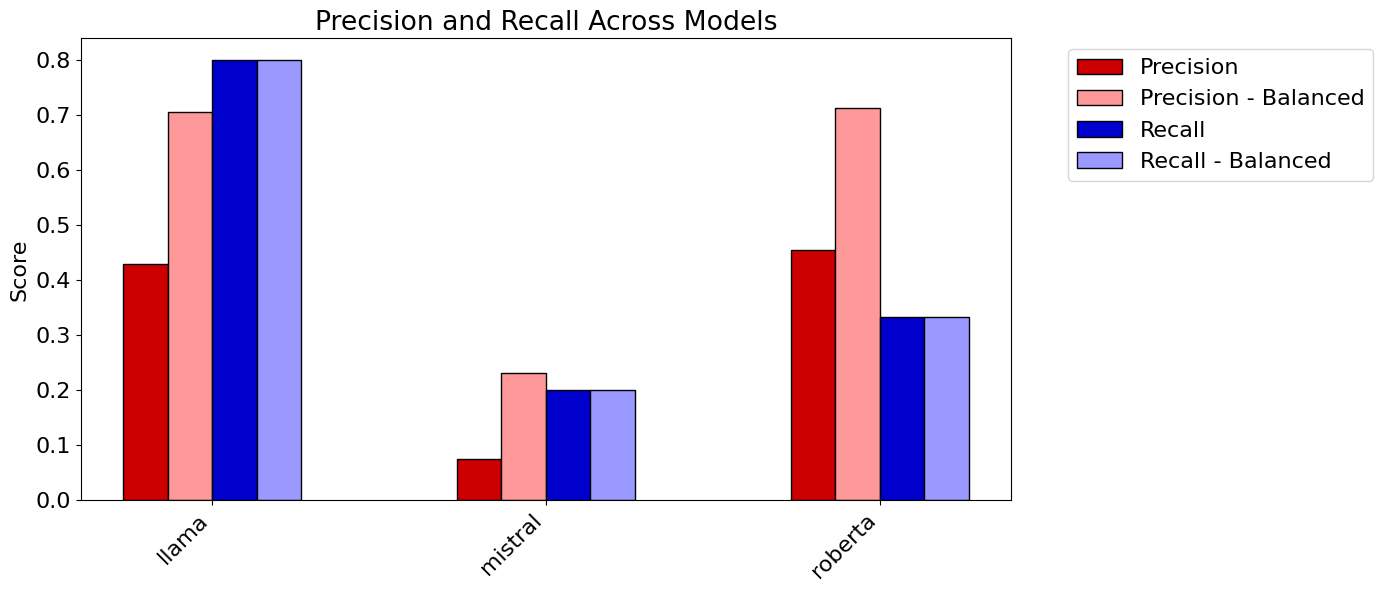

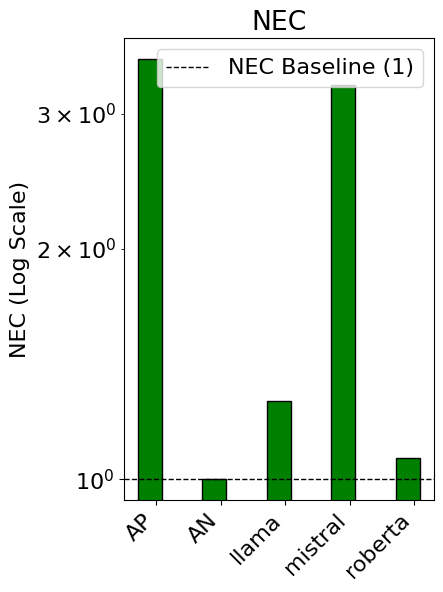

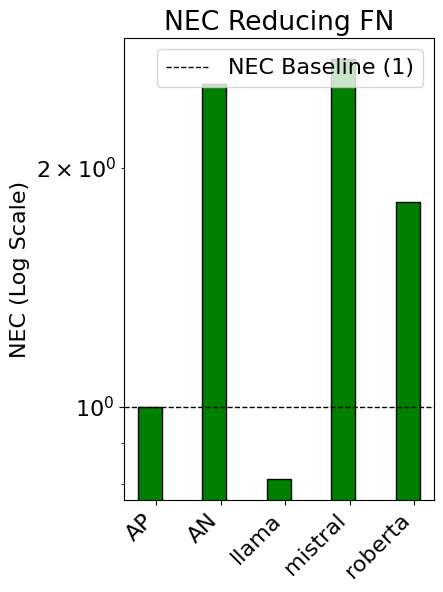

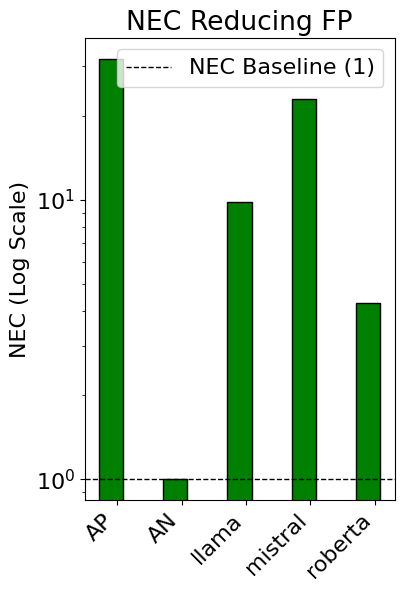

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load the dataset
file_path = "ITW_Eval.csv"
df = pd.read_csv(file_path)
df = df.sort_values(by="Model", key=lambda x: x.str.len())

df.replace("#DIV/0!", -1, inplace=True)
df.fillna(-1, inplace=True)
df["Precision"] = df["Precision"].astype(float)
df["Precision.1"] = df["Precision.1"].astype(float)

light_red = "#ff9999"
medium_red = "#ff6666"
dark_red = "#cc0000"

light_blue = "#9999ff"
dark_blue = "#0000cc"

light_green = "#98df8a"
dark_green = "#2ca02c"

no_pattern = None
diagonal_lines = "\\\\"

plt.rcParams.update({"font.size": 16})

def plot_precision_recall(df):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    metric_prompt_colors = {
        "Precision": dark_red,
        "Recall": dark_blue,
        "Precision.1": light_red,
        "Recall.1": light_blue,
    }
    
    unique_models = ["llama", "mistral", "roberta"]
    x_positions = {model: i * 3 for i, model in enumerate(unique_models)}
    bar_width = 0.4
    
    for model in unique_models:
        subset = df[df["Model"] == model]
        x_base = x_positions[model]
        
        ax.bar(x_base, subset["Precision"].values[0], width=bar_width, color=metric_prompt_colors["Precision"], label="Precision" if model == unique_models[0] else None, edgecolor="black")
        ax.bar(x_base + bar_width, subset["Precision.1"].values[0], width=bar_width, color=metric_prompt_colors["Precision.1"], label="Precision - Balanced" if model == unique_models[0] else None, edgecolor="black")
        ax.bar(x_base + 2 * bar_width, subset["Recall"].values[0], width=bar_width, color=metric_prompt_colors["Recall"], label="Recall" if model == unique_models[0] else None, edgecolor="black")
        ax.bar(x_base + 3 * bar_width, subset["Recall.1"].values[0], width=bar_width, color=metric_prompt_colors["Recall.1"], label="Recall - Balanced" if model == unique_models[0] else None, edgecolor="black")
    
    ax.set_xticks([x + 1.5 * bar_width for x in x_positions.values()])
    ax.set_xticklabels(unique_models, rotation=45, ha="right")
    ax.set_ylabel("Score")
    ax.set_title("Precision and Recall Across Models")
    ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    
    plt.savefig("precision_recall_itw.svg", bbox_inches="tight")
    plt.show()

def plot_nec(df, metric, title):
    fig, ax = plt.subplots(figsize=(4, 6))
    unique_models = df["Model"].unique()
    x_positions = {model: i * 2 for i, model in enumerate(unique_models)}
    bar_width = 0.75
    
    for model in unique_models:
        subset = df[df["Model"] == model]
        x_base = x_positions[model]
        ax.bar(x_base, subset[metric].values[0], width=bar_width, color="green", edgecolor="black")
    
    ax.axhline(1, linestyle="dashed", color="black", linewidth=1, label="NEC Baseline (1)")
    ax.set_yscale("log")
    ax.set_ylabel("NEC (Log Scale)")
    ax.set_xticks([x + 0.2 for x in x_positions.values()])
    ax.set_xticklabels(unique_models, rotation=45, ha="right")
    ax.set_title(title)
    ax.legend()
    
    plt.savefig(f"{title}_itw.svg", bbox_inches="tight")
    plt.show()

# Call functions to plot
plot_precision_recall(df)
plot_nec(df, "NEC", "NEC")
plot_nec(df, "NEC reduce FN", "NEC Reducing FN")
plot_nec(df, "Nec reduce FP", "NEC Reducing FP")


In [17]:
# Selecting relevant columns and renaming them for clarity
precision_recall_columns = ["Model", "Precision", "Recall"]
precision_recall_balanced_columns = ["Model", "Precision.1", "Recall.1"]
NEC_columns = ["Model", "NEC", "NEC reduce FN", "Nec reduce FP"]

precision_recall_caption = "Model performance: Precision and Recall."
precision_recall_balanced_caption = "Model performance: Precision and Recall in a balanced setting."
NEC_caption = "Model performance: NEC, NEC reducing FN, and NEC reducing FP."

columns_caption__format_items = [
    (precision_recall_columns, precision_recall_caption, "l l c c"),
    (precision_recall_balanced_columns, precision_recall_balanced_caption, "l l c c"),
    (NEC_columns, NEC_caption, "l l c c c"),
]

for columns, caption, format in columns_caption__format_items:
    df_filtered = df[columns]

    # Generate LaTeX table using to_latex method
    latex_table = df_filtered.to_latex(index=False, column_format=format, caption=caption, float_format="%.3f", position="H")

    # Output the LaTeX table
    print(latex_table)

\begin{table}[H]
\caption{Model performance: Precision and Recall.}
\begin{tabular}{l l c c}
\toprule
Model & Precision & Recall \\
\midrule
AP & 0.221 & 1.000 \\
AN & -1.000 & 0.000 \\
llama & 0.429 & 0.800 \\
mistral & 0.075 & 0.200 \\
roberta & 0.455 & 0.333 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[H]
\caption{Model performance: Precision and Recall in a balanced setting.}
\begin{tabular}{l l c c}
\toprule
Model & Precision.1 & Recall.1 \\
\midrule
AP & 0.500 & 1.000 \\
AN & -1.000 & 0.000 \\
llama & 0.706 & 0.800 \\
mistral & 0.231 & 0.200 \\
roberta & 0.714 & 0.333 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[H]
\caption{Model performance: NEC, NEC reducing FN, and NEC reducing FP.}
\begin{tabular}{l l c c c}
\toprule
Model & NEC & NEC reduce FN & Nec reduce FP \\
\midrule
AP & 3.533 & 1.000 & 31.800 \\
AN & 1.000 & 2.547 & 1.000 \\
llama & 1.267 & 0.811 & 9.800 \\
mistral & 3.267 & 2.736 & 23.000 \\
roberta & 1.067 & 1.811 & 4.267 \\
\bottomrule
\end{tab